In [22]:
import json
import pandas as pd
import requests
from pyjstat import pyjstat
import numpy as np
import sympy as sp
import datetime
import statsmodels.api as sm
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D




df = pd.read_csv('trafikkdata.csv')
df_historical = pd.read_csv('historical.csv')
geotag = pd.read_csv('geotag.csv')

#monthly data
df['daily_data'] = pd.to_datetime(df['daily_data'])
df['month'] = df['daily_data'].dt.month
df['year'] = df['daily_data'].dt.year

location_colors = {
    'Tromsøya': 'red',
    'Fastlandet': 'blue',
    'Kvaløya': 'orange',
    'Tilkoblinger til Tromsøya': 'green'}


# Filter DataFrame to only include specified date ranges for oppgave jobbing. Denne må endres til 05.
date_ranges = [(pd.to_datetime('2022-01-01'), pd.to_datetime('2022-05-31')),
               (pd.to_datetime('2023-01-01'), pd.to_datetime('2023-05-31'))]


#another datarange but from 2018-2023
date_ranges_historical = [(pd.to_datetime('2018-01-01'), pd.to_datetime('2018-05-31')),
                (pd.to_datetime('2019-01-01'), pd.to_datetime('2019-05-31')),
                (pd.to_datetime('2020-01-01'), pd.to_datetime('2020-05-31')),
                (pd.to_datetime('2021-01-01'), pd.to_datetime('2021-05-31')),
                (pd.to_datetime('2022-01-01'), pd.to_datetime('2022-05-31')),
                (pd.to_datetime('2023-01-01'), pd.to_datetime('2023-05-31'))]



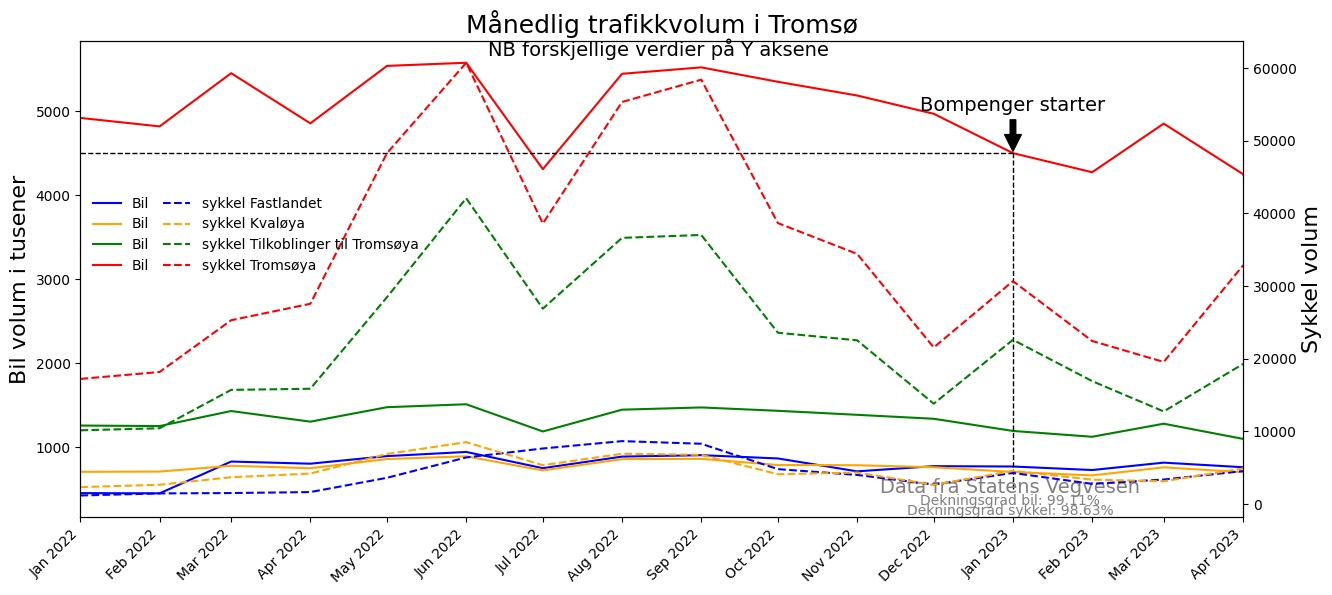

In [23]:


#group by name, heading, from_date, weekday, rush and sum volume and and take mean of coverage
df_location = df.groupby(['location', 'Vehicle type', 'month', 'year']).agg({'volume': 'sum', 'coverage': 'mean'}).reset_index()
#adding together year month again
df_location['month'] = df_location['year'].astype(str) + '-' + df_location['month'].astype(str)

df_location['month'] = pd.to_datetime(df_location['month'])





#plotting df_location by location and one line for car and one for bicycle
df_location_car = df_location[df_location['Vehicle type'] == 'car'].copy()
df_location_bicycle = df_location[df_location['Vehicle type'] == 'bicycle'].copy()

#starting plot
fig, ax = plt.subplots(figsize=(15, 7))

#plotting car with one line for each location
for location in df_location_car['location'].unique():
    df_location_car[df_location_car['location'] == location].plot(x='month', y='volume', label='Bil', ax=ax, color=location_colors[location])



#plotting bicycle with one line for each location on the other y axis with a dashed line
ax2 = ax.twinx()
for location in df_location_bicycle['location'].unique():
    df_location_bicycle[df_location_bicycle['location'] == location].plot(x='month', y='volume', label='sykkel ' + location, ax=ax2, linestyle="dashed",color=location_colors[location]) 






#x ticks as month names
ax.set_xticks(df_location_car['month'].unique())
ax.set_xticklabels(df_location_car['month'].dt.strftime('%b %Y').unique(), rotation=45)

#setting title and labels
ax.set_title('Månedlig trafikkvolum i Tromsø', fontsize=18)
ax.set_xlabel('', fontsize=16)
ax.set_ylabel('Bil volum i tusener', fontsize=16)
ax2.set_ylabel('Sykkel volum', fontsize=16)


ax.text(0.5, 0.97, 'NB forskjellige verdier på Y aksene ', transform=ax.transAxes, ha='center', fontsize=14, color='black')

ax.text(0.8, 0.05, 'Data fra Statens Vegvesen', transform=ax.transAxes, ha='center', fontsize=14, color='grey')

#ax in thousands
ax.yaxis.set_major_formatter(lambda x, pos: '{:.0f}'.format(x/1000) + '')

#removing space between line and y axis
ax.margins(x=0)
ax2.margins(x=0);


#line from 2023-01 up to car volume for 2023-01

#finding max value for car in 2023-01
max_car = df_location_car[df_location_car['month'] == '2023-01']['volume'].max()

#plotting line from 2023-01 up to max value for car in 2023-01
ax.plot([pd.to_datetime('2023-01'), pd.to_datetime('2023-01')], [500000, max_car], color='black', linestyle='--', linewidth=1)
#and a line from that point and to hte left
ax.plot([pd.to_datetime('2023-01'), pd.to_datetime('2022-01')], [max_car, max_car], color='black', linestyle='--', linewidth=1)

#text saying "Bompenger start" with arrow pointing to the line
ax.annotate('Bompenger starter', xy=(pd.to_datetime('2023-01'), max_car), xytext=(pd.to_datetime('2023-01'), max_car + 500000), arrowprops=dict(facecolor='black', shrink=0.05), ha='center', fontsize=14)


#plotting legend
ax.legend(loc='upper left', bbox_to_anchor=(0.0, 0.7), fontsize=10)
ax2.legend(loc='upper left', bbox_to_anchor=(0.06, 0.7), fontsize=10)
#legend no box
ax.get_legend().set_frame_on(False)
ax2.get_legend().set_frame_on(False)

#ax text with coverage %
ax.text(0.8, 0.025, 'Dekningsgrad bil: ' + str(round(df_location_car['coverage'].mean(), 2)) + '%', transform=ax.transAxes, ha='center', fontsize=10, color='grey')
ax.text(0.8, 0.005, 'Dekningsgrad sykkel: ' + str(round(df_location_bicycle['coverage'].mean(), 2)) + '%', transform=ax.transAxes, ha='center', fontsize=10, color='grey')

#xlim stop before 2023-05
ax.set_xlim(pd.to_datetime('2022-01'), pd.to_datetime('2023-04'))

#saving plot
plt.savefig('trafikkvolum_manedlig.png', bbox_inches='tight', dpi=300);



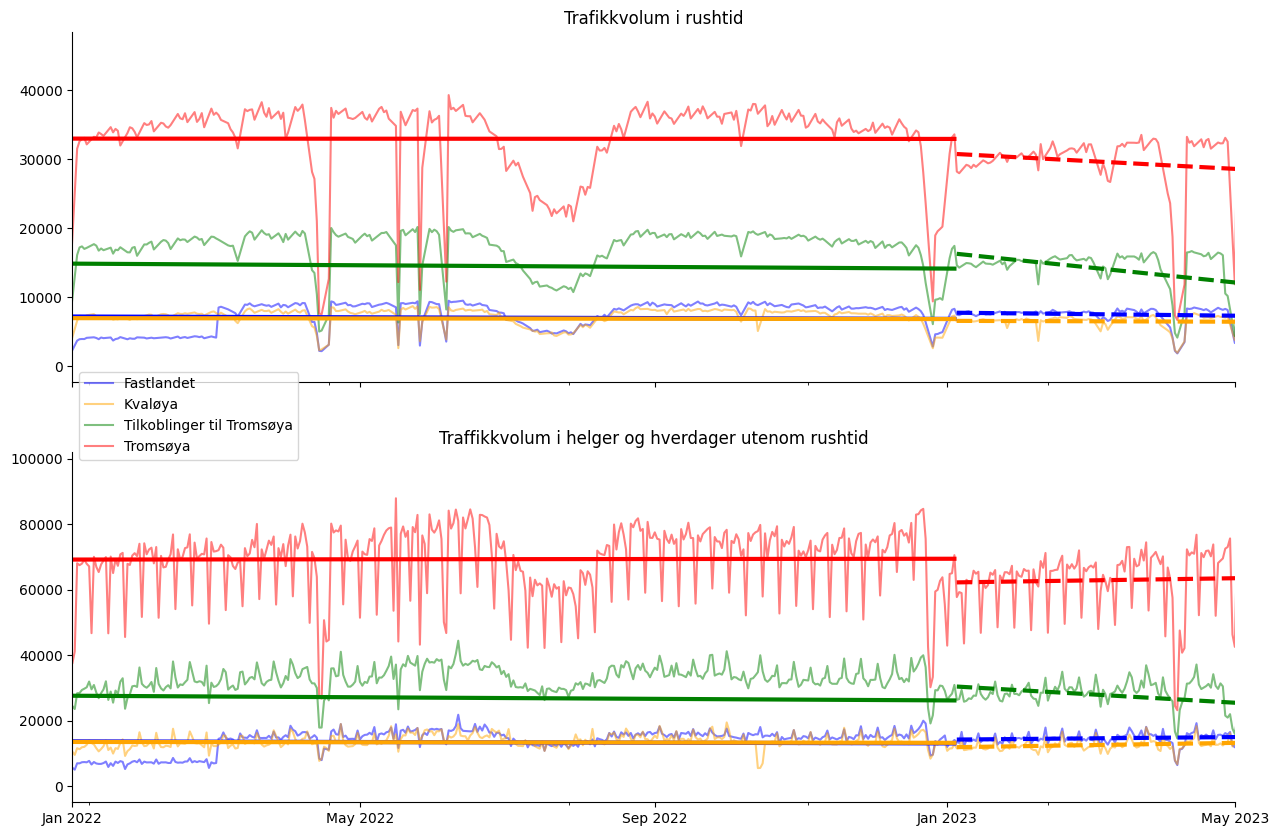

In [24]:

#When working with the data i didnt know that when writing to csv and later reading from csv it changed the dtypes of the columns. Therefor i need the next couple of lines of code.

#convert daily_data to object
df_historical['daily_data'] = df_historical['daily_data'].astype(str)
#convert bompenger to int64
df_historical['bompenger'] = df_historical['bompenger'].astype(np.int64)


df_historical = df_historical[df_historical['Vehicle type'] == 'car']
#Har brukt chatgpt

# Merge geotag with df_historical by name
df_historical = df_historical.merge(geotag, on='name', how='left')

# Create a GeoDataFrame from unique locations
unique_locations = df_historical[['name', 'lat', 'lon']].drop_duplicates()

# Separate locations based on the condition
included_locations = unique_locations[unique_locations['name'].isin(df_historical[df_historical['daily_data'] == '2018-01-01']['name'].unique())]
excluded_locations = unique_locations[~unique_locations['name'].isin(df_historical[df_historical['daily_data'] == '2018-01-01']['name'].unique())]


#drop id, lat, lon
df_historical = df_historical.drop(['id', 'lat', 'lon'], axis=1)


#keep only them
df_historical = df_historical[df_historical['name'].isin(df_historical[df_historical['daily_data'] == '2018-01-01']['name'].unique())]

#group by daily_data, weekday, rush, location, vehicle type, bompenger and sum volume and and take mean of coverage
df_historical = df_historical.groupby(['daily_data', 'weekday', 'rush', 'location', 'Vehicle type', 'bompenger']).agg({'volume': 'sum', 'coverage': 'mean'}).reset_index()

#weekday
df_historical['daily_data'] = pd.to_datetime(df_historical['daily_data'])


test123 = df_historical.copy()

#change daily_data to UNIX timestamp (in days)
df_historical['daily_data'] = df_historical['daily_data'].astype(np.int64) // (10**9 * 24 * 3600)

#arrange by daily_data
df_historical = df_historical.sort_values(by=['daily_data'])



#i will now make the same plot but using daily data and not monthly
#two plots with one for rush and one for not rush with lines for each location
fig, (ax, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

for location in df_historical['location'].unique():#reduce alpha
    df_historical[(df_historical['location'] == location) & (df_historical['rush'] == 'rush')].plot(x='daily_data', y='volume', label=location, ax=ax, color=location_colors[location], title='Trafikkvolum i rushtid', alpha=0.5)

for location in df_historical['location'].unique():
    df_historical[(df_historical['location'] == location) & (df_historical['rush'] == 'not rush')].plot(x='daily_data', y='volume', label=location, ax=ax2, color=location_colors[location], title="Traffikkvolum i helger og hverdager utenom rushtid", alpha=0.5)





# Regression line for each location before and after bompenger
for location in df_historical['location'].unique():
    for rush_value in ['rush', 'not rush']:
        for bompenger_value in [0, 1]:
            df_historical_subset = df_historical[(df_historical['location'] == location) & 
                                                 (df_historical['bompenger'] == bompenger_value) &
                                                 (df_historical['rush'] == rush_value)]

            # Prepare data for regression
            X = df_historical_subset['daily_data']
            y = df_historical_subset['volume']
            X = sm.add_constant(X)

            # Fit the model
            model = sm.OLS(y, X)
            results = model.fit()

            # Set linestyle based on bompenger_value
            linestyle = "dashed" if bompenger_value == 1 else "solid"

            # Plot regression line
            if rush_value == 'rush': #increase thickness of rush lines
                ax.plot(df_historical_subset['daily_data'], results.fittedvalues, linestyle=linestyle, color=location_colors[location], linewidth=3)
            else:
                ax2.plot(df_historical_subset['daily_data'], results.fittedvalues, linestyle=linestyle, color=location_colors[location], linewidth=3)



# Get the first day of each month in the daily_data column (converted back to datetime)
unique_dates = pd.date_range(pd.to_datetime(df_historical['daily_data'].min(), unit='D'), pd.to_datetime(df_historical['daily_data'].max(), unit='D'), freq='4MS')

# Convert unique_dates to UNIX timestamp (in days)
unique_dates_unix = (unique_dates.astype(np.int64) // (10**9 * 24 * 3600)).tolist()

# Set xticks for each month
ax.set_xticks(unique_dates_unix)
ax.set_xticklabels(unique_dates.strftime('%b %Y'), rotation=45)

#no space between line and y axis
ax.margins(x=0)
#no x label
ax2.set_xlabel('');

ax.get_legend().set_visible(False)
#spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)


#ax2 legend between plots
ax2.legend(loc='upper left', bbox_to_anchor=(0.0, 1.25), fontsize=10)



#plt.savefig
plt.savefig('lm_bil_daglig_bompenger.png', bbox_inches='tight', dpi=300)


#zoom in on 2022 and 2023
ax.set_xlim(pd.to_datetime('2022-01-01'), pd.to_datetime('2023-05-01'))
ax2.set_xlim(pd.to_datetime('2022-01-01'), pd.to_datetime('2023-05-01'))

#savefig
plt.savefig('lm_bil_daglig_bompenger_zoom.png', bbox_inches='tight', dpi=300);


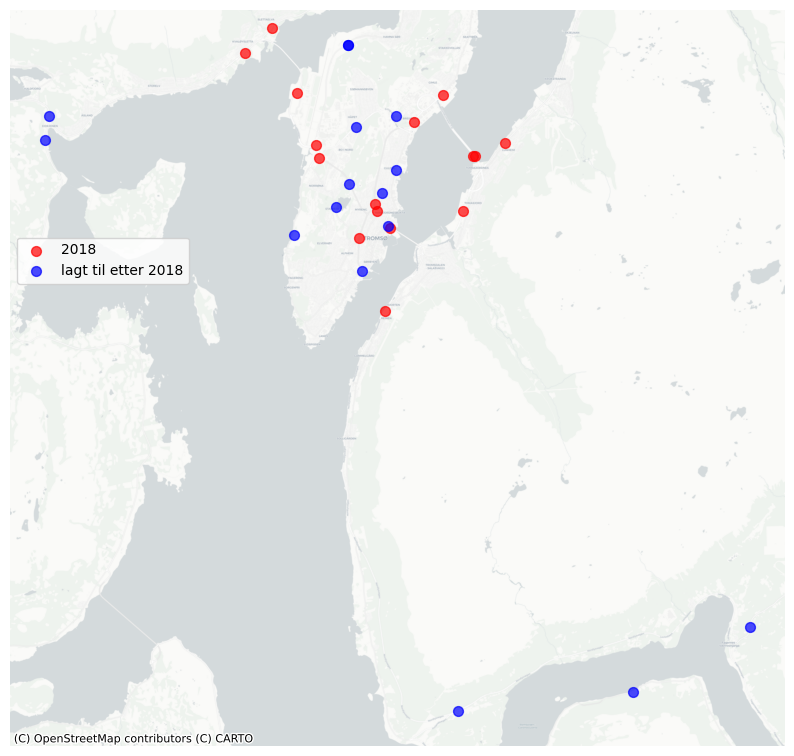

In [25]:


#Her er det brukt ChatGPT for å hjelpe meg med å lage kart. Jeg har spurt dne om å bruke Geopandas og contextily for å lage kartet ved bruk av lat og lon i datasettet og jeg har modifisert dette ganske mye.

# Create GeoDataFrames
gdf_included = gpd.GeoDataFrame(included_locations, geometry=gpd.points_from_xy(included_locations['lon'], included_locations['lat']))
gdf_excluded = gpd.GeoDataFrame(excluded_locations, geometry=gpd.points_from_xy(excluded_locations['lon'], excluded_locations['lat']))

# Set the CRS (Coordinate Reference System) to WGS84
gdf_included.crs = 'epsg:4326'
gdf_excluded.crs = 'epsg:4326'

# Reproject to Web Mercator
gdf_included = gdf_included.to_crs(epsg=3857)
gdf_excluded = gdf_excluded.to_crs(epsg=3857)

# Create a map
fig, ax = plt.subplots(figsize=(10, 10))

# Plot red markers for included names
gdf_included.plot(ax=ax, markersize=50, color='red', alpha=0.7, label="2018")

# Plot blue markers for excluded names
gdf_excluded.plot(ax=ax, markersize=50, color='blue', alpha=0.7, label="lagt til etter 2018")

# Add basemap using contextily
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Set axis limits to zoom in on the area of interest
ax.set_xlim(gdf_excluded.geometry.x.min() - 2500, gdf_excluded.geometry.x.max() + 2500)
ax.set_ylim(gdf_excluded.geometry.y.min() - 2500, gdf_excluded.geometry.y.max() + 2500)


#drop all spines
ax.axis('off')
#drop labels and ticks
ax.set_xticks([])
ax.set_yticks([])
ax.legend(loc='upper left', bbox_to_anchor=(0.0, 0.7), fontsize=10)

#plt savefig
plt.savefig('kart.png', dpi=300);



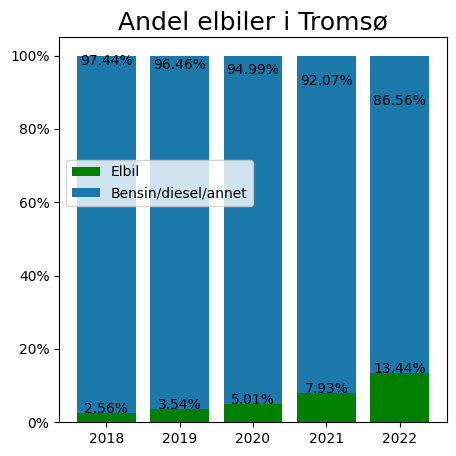

In [26]:
#henter inn data på hvilke typer biler som er i Tromsø. Kommer frem til ca 15% elbiler i 2022
postUrl = "https://data.ssb.no/api/v0/no/table/07849/"


apiQuery = {
  "query": [
    {
      "code": "Region",
      "selection": {
        "filter": "agg:KommSummer",
        "values": [
          "K-5401"
        ]
      }
    },
    {
      "code": "DrivstoffType",
      "selection": {
        "filter": "item",
        "values": [
          "1",
          "2",
          "3",
          "4",
          "5",
          "6"
        ]
      }
    },
    {
      "code": "ContentsCode",
      "selection": {
        "filter": "item",
        "values": [
          "Personbil1"
        ]
      }
    },
    {
      "code": "Tid",
      "selection": {
        "filter": "item",
        "values": [
          "2018",
          "2019",
          "2020",
          "2021",
          "2022"
        ]
      }
    }
  ],
  "response": {
    "format": "json-stat2"
  }
}

# Funksjon for å konvertere uttrekket til 2 dataframes, tar 2 paramtre

def apiToDataframe(postUrl, query):

    # postUrl som spørringen skal postes mot
    # Spørringen og endepunktet til API-et kan hentes fra Statistikkbanken.

    res = requests.post(postUrl, json=query)
    # legger resultat i ds. DS har i tillegg en del metadata
    ds = pyjstat.Dataset.read(res.text)
    # skriver resultatet til to dataframes
    # først dataframe med tekst
    df = ds.write('dataframe')
    # deretter dataframe med koder
    df_id = ds.write('dataframe', naming='id')
    # returnerer også ds i tilfelle en trenger metadata
    return df, df_id, ds

df_bilandeler, df_id, ds = apiToDataframe(postUrl, apiQuery)


#new column. 1 if drivstofftype contains "El." and 0 if not
df_bilandeler = df_bilandeler.copy()
df_bilandeler['elbil'] = np.where(df_bilandeler['drivstofftype'].str.contains('El.'), 1, 0)
#group by year and elbil
df_bilandeler = df_bilandeler.groupby(['år', 'elbil']).agg({'value': 'sum'}).reset_index()
#elbil percent of total per year
df_bilandeler['elbil_prosent'] = df_bilandeler.groupby('år', group_keys=False)['value'].apply(lambda x: x / float(x.sum()) * 100)

#plot the two percentages as stackplot per year
fig, ax = plt.subplots(figsize=(5, 5))

#bar plot each year stacked on top of each other. 
ax.bar(df_bilandeler['år'], df_bilandeler['elbil_prosent'], color='green', label='Elbil')
ax.bar(df_bilandeler['år'], 100 - df_bilandeler['elbil_prosent'], bottom=df_bilandeler['elbil_prosent'], color='#1B79AC', label='Bensin/diesel/annet')


for index, row in df_bilandeler.iterrows():
    ax.text(row['år'], row['elbil_prosent'], str(round(row['elbil_prosent'], 2)) + '%', ha='center', fontsize=10, color='black')


#percent on y axis
ax.yaxis.set_major_formatter(lambda x, pos: '{:.0f}'.format(x) + '%')


#legend
ax.legend(loc='upper left', bbox_to_anchor=(0.0, 0.7), fontsize=10)

#title and labels
ax.set_title('Andel elbiler i Tromsø', fontsize=18)
ax.set_xlabel('', fontsize=16)
ax.set_ylabel('', fontsize=16)


plt.savefig('elbil_andeler.png', bbox_inches='tight', dpi=300);




In [27]:


postUrl = "https://data.ssb.no/api/v0/no/table/12576/"


apiQuery = {
  "query": [
    {
      "code": "Region",
      "selection": {
        "filter": "vs:FylkerAlle",
        "values": [
          "54",
          "19",
          "20"
        ]
      }
    },
    {
      "code": "Kjoretoytype",
      "selection": {
        "filter": "item",
        "values": [
          "15"
        ]
      }
    },
    {
      "code": "DrivstoffType",
      "selection": {
        "filter": "item",
        "values": [
          "1",
          "2",
          "18",
          "14",
          "15",
          "16",
          "17",
          "3",
          "4",
          "13",
          "7"
        ]
      }
    },
    {
      "code": "ContentsCode",
      "selection": {
        "filter": "item",
        "values": [
          "GjsnittKjorelengde"
        ]
      }
    },
    {
      "code": "Tid",
      "selection": {
        "filter": "item",
        "values": [
          "2018",
          "2019",
          "2020",
          "2021",
          "2022"
        ]
      }
    }
  ],
  "response": {
    "format": "json-stat2"
  }
}


def apiToDataframe(postUrl, query):

    # postUrl som spørringen skal postes mot
    # Spørringen og endepunktet til API-et kan hentes fra Statistikkbanken.

    res = requests.post(postUrl, json=query)
    # legger resultat i ds. DS har i tillegg en del metadata
    ds = pyjstat.Dataset.read(res.text)
    # skriver resultatet til to dataframes
    # først dataframe med tekst
    df = ds.write('dataframe')
    # deretter dataframe med koder
    df_id = ds.write('dataframe', naming='id')
    # returnerer også ds i tilfelle en trenger metadata
    return df, df_id, ds

df_kjorelengde, df_id, ds = apiToDataframe(postUrl, apiQuery)

df_kjorelengde['region'] = df_kjorelengde['region'].str.replace('Troms og Finnmark - Romsa ja Finnmárku', 'Troms og Finnmark')

df_kjorelengde = df_kjorelengde.replace(np.nan, 0)
#i remove rows with Troms og Finnmark and put it in a new dataframe
df_troms_og_finnmark = df_kjorelengde[df_kjorelengde['region'] == 'Troms og Finnmark']
df_troms = df_kjorelengde[df_kjorelengde['region'] != 'Troms og Finnmark']
#I combine all values for nordland and troms og finnmark and group by år and bustadland
#mean of value for each year and drivstofftype
df_troms = df_troms.groupby(['år','drivstofftype']).mean(numeric_only=True)
df_troms_og_finnmark = df_troms_og_finnmark.groupby(['år','drivstofftype']).mean(numeric_only=True)
#index as int type
df_troms.index = df_troms.index.set_levels(df_troms.index.levels[0].astype(int), level=0)
df_troms_og_finnmark.index = df_troms_og_finnmark.index.set_levels(df_troms_og_finnmark.index.levels[0].astype(int), level=0)
#df_troms drop rows år > 2020
df_troms = df_troms[df_troms.index.get_level_values('år') < 2020]
df_troms_og_finnmark = df_troms_og_finnmark[df_troms_og_finnmark.index.get_level_values('år') >= 2020]
#rowbind
df_kjorelengde = pd.concat([df_troms, df_troms_og_finnmark])
#index to column names
df_kjorelengde = df_kjorelengde.reset_index(level=['drivstofftype'])

#new col for drivstofftype contains "Elektrisitet" 1 for yes 0 for no
df_kjorelengde['elbil'] = np.where(df_kjorelengde['drivstofftype'] == 'Elektrisitet', 1, 0)

#if value == 0 drop row
df_kjorelengde = df_kjorelengde[df_kjorelengde['value'] != 0]


#group by elbil and år
df_kjorelengde = df_kjorelengde.groupby(['år', 'elbil']).mean(numeric_only=True)
df_kjorelengde = df_kjorelengde.reset_index(level=['elbil'])
df_kjorelengde = df_kjorelengde.reset_index(level=['år'])
df_kjorelengde = df_kjorelengde.pivot(index='år', columns='elbil', values='value')
#siste steg. regne ut kjørelengder
kjorelengde_2022 = df_kjorelengde[df_kjorelengde.index == 2022]
#bensinbil is row1 col 1
kjorelengde_2022_bensinbil = round(kjorelengde_2022.iloc[0, 0])
kjorelengde_2022_elbil = round(kjorelengde_2022.iloc[0, 1])




postUrl = "https://data.ssb.no/api/v0/no/table/12852/"


apiQuery = {
  "query": [
    {
      "code": "Region",
      "selection": {
        "filter": "vs:KommunerFastIkkeFast",
        "values": [
          "5401"
        ]
      }
    },
    {
      "code": "MaaleMetode",
      "selection": {
        "filter": "item",
        "values": [
          "02"
        ]
      }
    },
    {
      "code": "ArbBostedRegion",
      "selection": {
        "filter": "item",
        "values": [
          "2"
        ]
      }
    },
    {
      "code": "Alder",
      "selection": {
        "filter": "item",
        "values": [
          "Ialt"
        ]
      }
    },
    {
      "code": "AvtaltVanlig",
      "selection": {
        "filter": "item",
        "values": [
          "0"
        ]
      }
    },
    {
      "code": "ContentsCode",
      "selection": {
        "filter": "item",
        "values": [
          "Manedslonn"
        ]
      }
    },
    {
      "code": "Tid",
      "selection": {
        "filter": "item",
        "values": [
          "2022"
        ]
      }
    }
  ],
  "response": {
    "format": "json-stat2"
  }
}


def apiToDataframe(postUrl, query):

    # postUrl som spørringen skal postes mot
    # Spørringen og endepunktet til API-et kan hentes fra Statistikkbanken.

    res = requests.post(postUrl, json=query)
    # legger resultat i ds. DS har i tillegg en del metadata
    ds = pyjstat.Dataset.read(res.text)
    # skriver resultatet til to dataframes
    # først dataframe med tekst
    df = ds.write('dataframe')
    # deretter dataframe med koder
    df_id = ds.write('dataframe', naming='id')
    # returnerer også ds i tilfelle en trenger metadata
    return df, df_id, ds

df_lonn, df_id, ds = apiToDataframe(postUrl, apiQuery)
lonn = df_lonn.iloc[0, -1]*12

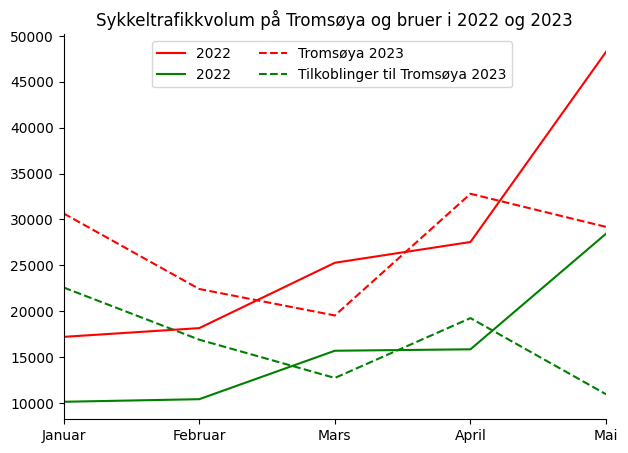

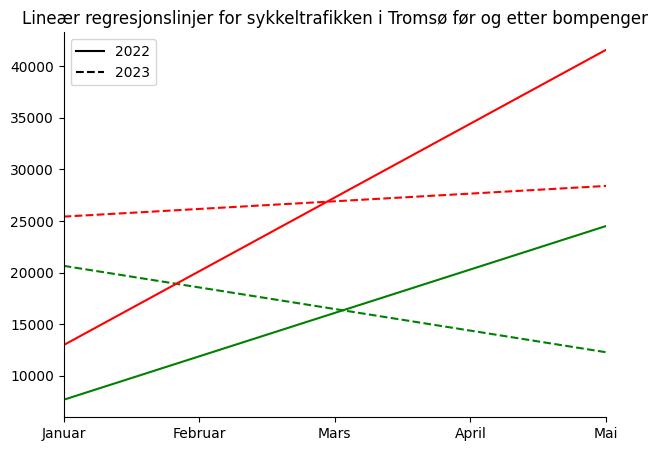

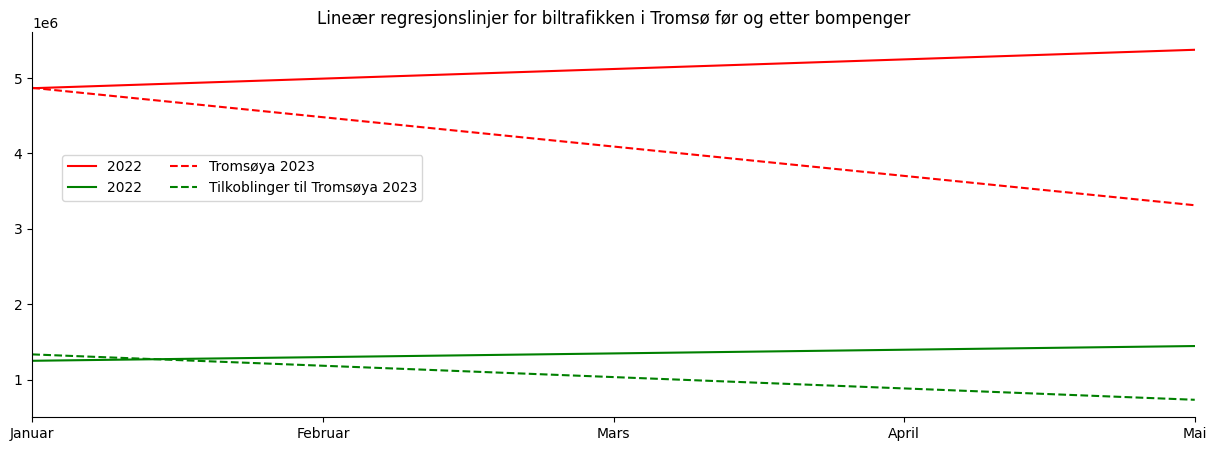

In [28]:

#from location drop kvaløya and fastlandet
df_location_bicycle = df_location_bicycle[~df_location_bicycle['location'].isin(['Kvaløya', 'Fastlandet'])].copy()
df_location_car = df_location_car[~df_location_car['location'].isin(['Kvaløya', 'Fastlandet'])].copy()


df_location_car = df_location_car[df_location_car['month'].apply(lambda x: any(start <= x <= end for start, end in date_ranges))].copy()
df_location_bicycle = df_location_bicycle[df_location_bicycle['month'].apply(lambda x: any(start <= x <= end for start, end in date_ranges))].copy()



#month as str
df_location_bicycle['month'] = df_location_bicycle['month'].astype(str)
#from month column remove first 5 characters and final 3
df_location_bicycle['month'] = df_location_bicycle['month'].str[5:-3]
#as int
df_location_bicycle['month'] = df_location_bicycle['month'].astype(int)

#month as str
df_location_car['month'] = df_location_car['month'].astype(str)
#from month column remove first 5 characters and final 3
df_location_car['month'] = df_location_car['month'].str[5:-3]
#as int
df_location_car['month'] = df_location_car['month'].astype(int)


fig, ax = plt.subplots(figsize=(7, 5))
for location in df_location_bicycle['location'].unique():
    for year in [2022, 2023]:
        df_location_bicycle_subset = df_location_bicycle[(df_location_bicycle['location'] == location) & (df_location_bicycle['year'] == year)]

        # Setter linestyle based on bompenger_value
        linestyle = "dashed" if year == 2023 else "solid"

        #label
        label = location + ' ' + str(year) if year == 2023 else str(year)
        
        # Plotter
        ax.plot(df_location_bicycle_subset['month'], df_location_bicycle_subset['volume'], linestyle=linestyle, color=location_colors[location], label=label)




ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('Sykkeltrafikkvolum på Tromsøya og bruer i 2022 og 2023')


handles, labels = ax.get_legend_handles_labels() #lagrer handles og labels i variabler slik at jeg kan endre rekkefølge
# vil ha 2022 verdiene først slik at jeg kan enkelt sette ncol=2
test = [2, 0, 3, 1]

# endrer rekkefølle etter listen
handles = [handles[i] for i in test]
labels = [labels[i] for i in test]

ax.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.15, 1), fontsize=10, ncol=2)

# Set xticks for each month
ax.set_xticks(range(1,6))
ax.set_xticklabels(['Januar', 'Februar', 'Mars', 'April', 'Mai'])

ax.set_xlim([1, 5])

#no top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('sykkel_manedlig_tromsoya.png', bbox_inches='tight', dpi=300);



#ny figur


fig, ax = plt.subplots(figsize=(7, 5))
for location in df_location_bicycle['location'].unique():
    for year in [2022, 2023]:
        df_location_bicycle_subset = df_location_bicycle[(df_location_bicycle['location'] == location) & (df_location_bicycle['year'] == year)]
        X = df_location_bicycle_subset['month']
        y = df_location_bicycle_subset['volume']
        X = sm.add_constant(X)

        
        model = sm.OLS(y, X)
        results = model.fit() #setter regresjonslinjene

        # Setter linestyle based on bompenger_value
        linestyle = "dashed" if year == 2023 else "solid"
        
        # Plotter
        ax.plot(df_location_bicycle_subset['month'], results.fittedvalues, linestyle=linestyle, color=location_colors[location], label=str(year))



#fargene ble litt rar så jeg omsetter fargene igjen
for location in df_location_bicycle['location'].unique():
    ax.plot([], [], linestyle="solid", color=location_colors[location], label='2022')
    ax.plot([], [], linestyle="dashed", color=location_colors[location], label=location + ' 2023') 



ax.set_title('Lineær regresjonslinjer for sykkeltrafikken i Tromsø før og etter bompenger')




#setter legend i plot 2 for å vise at det er 2022 og 2023. må bruke line2d for å sette custom legend
ax.legend([Line2D([0], [0], color='black', linestyle='solid'), Line2D([0], [0], color='black', linestyle='dashed')], ['2022', '2023'])



# Set xticks for each month
ax.set_xticks(range(1,6))
ax.set_xticklabels(['Januar', 'Februar', 'Mars', 'April', 'Mai'])

ax.set_xlim([1, 5])



#no top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('lm_sykkel_manedlig_bompenger.png', bbox_inches='tight', dpi=300);



#Biler

fig, ax = plt.subplots(figsize=(15, 5))
for location in df_location_car['location'].unique():
    for year in [2022, 2023]:
        df_location_car_subset = df_location_car[(df_location_car['location'] == location) & (df_location_car['year'] == year)]
        X = df_location_car_subset['month']
        y = df_location_car_subset['volume']
        X = sm.add_constant(X)

        
        model = sm.OLS(y, X)
        results = model.fit() #setter regresjonslinjene

        linestyle = "dashed" if year == 2023 else "solid"
        label = location + ' ' + str(year) if year == 2023 else str(year)
        # Plotter
        ax.plot(df_location_car_subset['month'], results.fittedvalues, linestyle=linestyle, color=location_colors[location], label=label)

#title
ax.set_title('Lineær regresjonslinjer for biltrafikken i Tromsø før og etter bompenger')


handles, labels = ax.get_legend_handles_labels() #lagrer handles og labels i variabler slik at jeg kan endre rekkefølge
# vil ha 2022 verdiene først slik at jeg kan enkelt sette ncol=2

# endrer rekkefølle etter listen
handles = [handles[i] for i in test]
labels = [labels[i] for i in test]

ax.legend(handles, labels, loc='upper left', bbox_to_anchor=(0.02, 0.7), fontsize=10, ncol=2)


# Set xticks for each month
ax.set_xticks(range(1,6))
ax.set_xticklabels(['Januar', 'Februar', 'Mars', 'April', 'Mai'])

ax.set_xlim([1, 5])



#no top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#savefig
plt.savefig('lm_bil_manedlig_bompenger.png', bbox_inches='tight', dpi=300);

In [29]:
#gjennomsnittlig kjørelengde per år
#elbil 11500
#bensinbil 13500
#rushtid 28.8 bensin, 14,4 el
#ikke rushtid 9.6 bensin, 4,8 el
#30 prosent av trafikk er i rush
#70 prosent av trafikk er ikke i rush


#går vi ut ifra at folk kjører hver dag i rush
#elbil 11500 / 365 = 31.5 km per dag
#bensinbil 13500 / 365 = 37 km per dag
elbil_kjorelengde = kjorelengde_2022_elbil / 365
elbil_rushpris = 14.4
elbil_ikkerushpris = 4.8
elbilrush_30 = (elbil_rushpris*2)/elbil_kjorelengde * 0.3
elbilikkerush_30 = (elbil_ikkerushpris*2)/elbil_kjorelengde * 0.7
 

elbilrush_100 = (elbil_rushpris*2)/elbil_kjorelengde * 1
elbilikkerush_100 = (elbil_ikkerushpris*2)/elbil_kjorelengde * 0

elbilrush_0 = (elbil_rushpris*2)/elbil_kjorelengde * 0
elbilikkerush_0 = (elbil_ikkerushpris*2)/elbil_kjorelengde * 1

elbil_kilometerkost30 = elbilrush_30 + elbilikkerush_30
elbil_kilometerkost100 = elbilrush_100 + elbilikkerush_100
elbil_kilometerkost0 = elbilrush_0 + elbilikkerush_0


bensinbil_kjorelengde = kjorelengde_2022_bensinbil / 365
bensinbil_rushpris = 28.8
bensinbil_ikkerushpris = 9.6
bensinbilrush_30 = (bensinbil_rushpris*2)/bensinbil_kjorelengde * 0.3
bensinbilikkerush_30 = (bensinbil_ikkerushpris*2)/bensinbil_kjorelengde * 0.7

bensinbilrush_100 = (bensinbil_rushpris*2)/bensinbil_kjorelengde * 1
bensinbilikkerush_100 = (bensinbil_ikkerushpris*2)/bensinbil_kjorelengde * 0

bensinbilrush_0 = (bensinbil_rushpris*2)/bensinbil_kjorelengde * 0
bensinbilikkerush_0 = (bensinbil_ikkerushpris*2)/bensinbil_kjorelengde * 1


bensinbil_kilometerkost30 = bensinbilrush_30 + bensinbilikkerush_30
bensinbil_kilometerkost100 = bensinbilrush_100 + bensinbilikkerush_100
bensinbil_kilometerkost0 = bensinbilrush_0 + bensinbilikkerush_0


display(bensinbil_kilometerkost30, bensinbil_kilometerkost100, bensinbil_kilometerkost0, elbil_kilometerkost30, elbil_kilometerkost100, elbil_kilometerkost0)

0.9100560019478937

1.7063550036523008

0.5687850012174336

0.49465325569084173

0.9274748544203283

0.3091582848067761

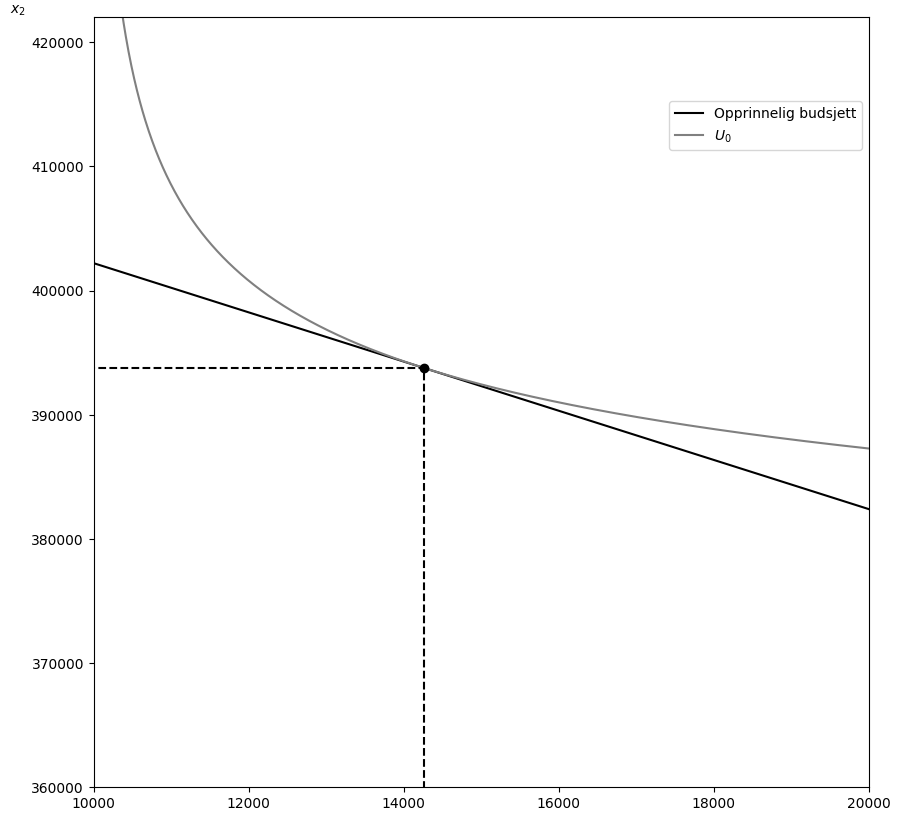

In [30]:

bta_1, bta_2, gma_1, gma_2 = sp.symbols('\u03B2_1 \u03B2_2 \gamma_1 \gamma_2', real=True, positive=True)
x_1, x_2, p_1, p_2, m=sp.symbols("x_1 x_2 p_1 p_2 m", real=True, positive=True)
x_1_eq = gma_1 + (bta_1/p_1)*(m-p_1*gma_1-p_2*gma_2)
x_2_eq = gma_2 + (bta_2/p_2)*(m-p_1*gma_1-p_2*gma_2)


nytte_sg = bta_1*sp.log(x_1-gma_1) + (1-bta_1)*sp.log(x_2-gma_2)
V = nytte_sg.subs([(x_1, x_1_eq), (x_2, x_2_eq)]) 

x_1_elbil_bil = float(x_1_eq.subs([(bta_1, 0.2), (gma_1, 10000), (gma_2, 360000), (m, 422000), (p_1, 1.98), (p_2, 1)]))
x_2_elbil_bil = float(x_2_eq.subs([(bta_2, 0.8), (gma_1, 10000), (gma_2, 360000), (m, 422000), (p_1, 1.98), (p_2, 1)]))
elbil_nytte = float(V.subs([(bta_1, 0.2),(bta_2, 0.8), (gma_1, 10000), (gma_2, 360000), (m, 422000), (p_1, 1.98), (p_2, 1)]))

x_1_elbil_bil_sc1 = float(x_1_eq.subs([(bta_1, 0.2), (gma_1, 10000), (gma_2, 360000), (m, 422000), (p_1, 2.47), (p_2, 1)]))
x_2_elbil_bil_sc1 = float(x_2_eq.subs([(bta_2, 0.8), (gma_1, 10000), (gma_2, 360000), (m, 422000), (p_1, 2.47), (p_2, 1)]))
elbil_nytte_sc1 = float(V.subs([(bta_1, 0.2),(bta_2, 0.8), (gma_1, 10000), (gma_2, 360000), (m, 422000), (p_1, 2.47), (p_2, 1)]))

x_1_elbil_bil_sc2 = float(x_1_eq.subs([(bta_1, 0.2), (gma_1, 10000), (gma_2, 360000), (m, 422000), (p_1, 2.91), (p_2, 1)]))
x_2_elbil_bil_sc2 = float(x_2_eq.subs([(bta_2, 0.8), (gma_1, 10000), (gma_2, 360000), (m, 422000), (p_1, 2.91), (p_2, 1)]))
elbil_nytte_sc2 = float(V.subs([(bta_1, 0.2),(bta_2, 0.8), (gma_1, 10000), (gma_2, 360000), (m, 422000), (p_1, 2.91), (p_2, 1)]))

x_1_elbil_bil_sc3 = float(x_1_eq.subs([(bta_1, 0.2), (gma_1, 10000), (gma_2, 360000), (m, 422000), (p_1, 2.29), (p_2, 1)]))
x_2_elbil_bil_sc3 = float(x_2_eq.subs([(bta_2, 0.8), (gma_1, 10000), (gma_2, 360000), (m, 422000), (p_1, 2.29), (p_2, 1)]))
elbil_nytte_sc3 = float(V.subs([(bta_1, 0.2),(bta_2, 0.8), (gma_1, 10000), (gma_2, 360000), (m, 422000), (p_1, 2.29), (p_2, 1)]))



def budsjett(M, x_1, p_1, p_2):
    return M/p_2 - (p_1*x_1/p_2)


def ind_k_fn(bta_1,gma_1,gma_2,x_1,U_0):
    return gma_2 + np.exp((bta_1*np.log(x_1-gma_1)-U_0)/(bta_1-1))

# Create an array X that ensures x-gamma > 0
X = np.linspace (10000.01,100000,10000)

fig, ax = plt.subplots(figsize=(10, 10))

# Remove numbers from the axes
#ax.set_xticks([])
#ax.set_yticks([])

ax.set_ylabel('$x_2$', loc='top', rotation=0)

ax.plot(X, budsjett(422000, X, 1.98, 1), color='black', label='Opprinnelig budsjett')
ax.plot(X, ind_k_fn(.2,10000,360000,X,elbil_nytte), color='grey',label='$U_0$')

ax.plot(x_1_elbil_bil, x_2_elbil_bil , marker='o', color='black')

ax.vlines(x_1_elbil_bil, 0, x_2_elbil_bil, ls='dashed', color='black')
ax.hlines(x_2_elbil_bil, 0, x_1_elbil_bil, ls='dashed', color='black')

# Set x limits
ax.set_xlim(10000, 20000)
ax.set_ylim(360000, 422000)
# Show the legend
ax.legend(bbox_to_anchor=(1,0.9))
plt.show()

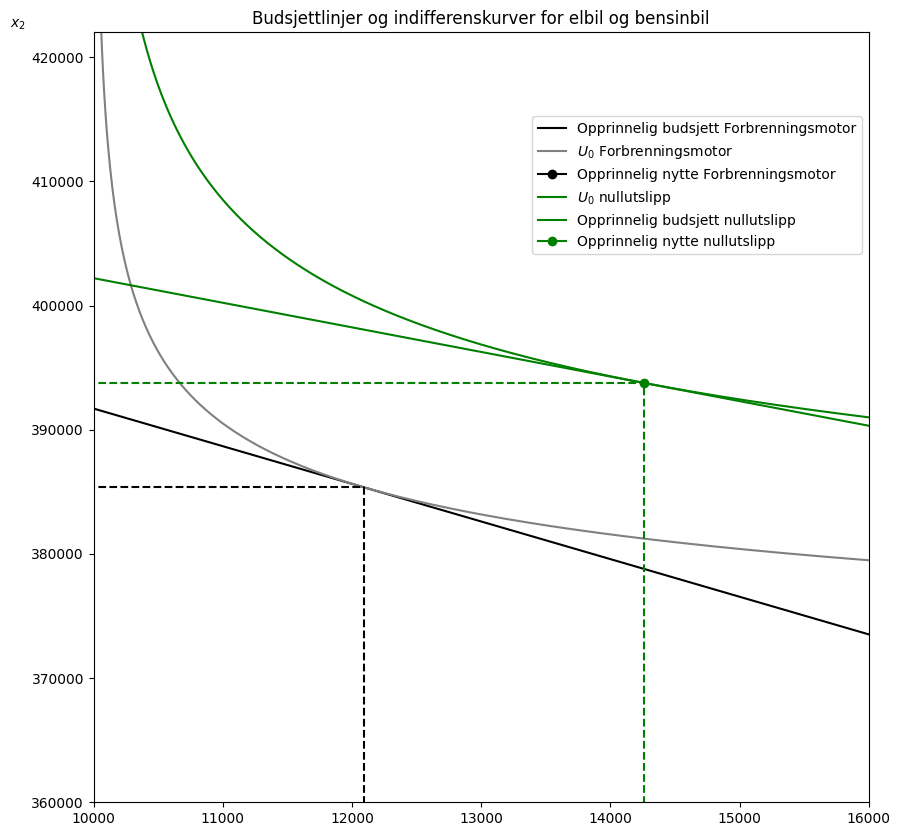

In [31]:

bta_1, bta_2, gma_1, gma_2 = sp.symbols('\u03B2_1 \u03B2_2 \gamma_1 \gamma_2', real=True, positive=True)
x_1, x_2, p_1, p_2, m=sp.symbols("x_1 x_2 p_1 p_2 m", real=True, positive=True)
x_1_eq = gma_1 + (bta_1/p_1)*(m-p_1*gma_1-p_2*gma_2)
x_2_eq = gma_2 + (bta_2/p_2)*(m-p_1*gma_1-p_2*gma_2)


nytte_sg = bta_1*sp.log(x_1-gma_1) + (1-bta_1)*sp.log(x_2-gma_2)
V = nytte_sg.subs([(x_1, x_1_eq), (x_2, x_2_eq)]) 

x_1_bensin_bil = float(x_1_eq.subs([(bta_1, 0.2), (gma_1, 10000), (gma_2, 360000), (m, 422000), (p_1, 3.03), (p_2, 1)]))
x_2_bensin_bil = float(x_2_eq.subs([(bta_2, 0.8), (gma_1, 10000), (gma_2, 360000), (m, 422000), (p_1, 3.03), (p_2, 1)]))
bensin_nytte = float(V.subs([(bta_1, 0.2),(bta_2, 0.8), (gma_1, 10000), (gma_2, 360000), (m, 422000), (p_1, 3.03), (p_2, 1)]))

def budsjett(M, x_1, p_1, p_2):
    return M/p_2 - (p_1*x_1/p_2)


def ind_k_fn(bta_1,gma_1,gma_2,x_1,U_0):
    return gma_2 + np.exp((bta_1*np.log(x_1-gma_1)-U_0)/(bta_1-1))

# Create an array X that ensures x-gamma > 0
X = np.linspace (10000.01,100000,10000)

fig, ax = plt.subplots(figsize=(10, 10))

# Remove numbers from the axes
#ax.set_xticks([])
#ax.set_yticks([])

ax.set_ylabel('$x_2$', loc='top', rotation=0)

ax.plot(X, budsjett(422000, X, 3.03, 1), color='black', label='Opprinnelig budsjett Forbrenningsmotor')
ax.plot(X, ind_k_fn(.2,10000,360000,X,bensin_nytte), color='grey',label='$U_0$ Forbrenningsmotor')

ax.plot(x_2_bensin_bil, x_2_bensin_bil , marker='o', color='black', label="Opprinnelig nytte Forbrenningsmotor")

ax.vlines(x_1_bensin_bil, 0, x_2_bensin_bil, ls='dashed', color='black')
ax.hlines(x_2_bensin_bil, 0, x_1_bensin_bil, ls='dashed', color='black')


ax.plot(X, ind_k_fn(.2,10000,360000,X,elbil_nytte), color='green',label='$U_0$ nullutslipp')
ax.plot(X, budsjett(422000, X, 1.98, 1), color='green', label='Opprinnelig budsjett nullutslipp')
ax.plot(x_1_elbil_bil, x_2_elbil_bil , marker='o', color='green', label="Opprinnelig nytte nullutslipp")

ax.vlines(x_1_elbil_bil, 0, x_2_elbil_bil, ls='dashed', color='green')
ax.hlines(x_2_elbil_bil, 0, x_1_elbil_bil, ls='dashed', color='green')


#title
ax.set_title('Budsjettlinjer og indifferenskurver for elbil og bensinbil')

# Set x limits
ax.set_xlim(10000, 16000)
ax.set_ylim(360000, 422000)
# Show the legend
ax.legend(bbox_to_anchor=(1,0.9))
plt.show()

In [32]:

bta_1, bta_2, gma_1, gma_2 = sp.symbols('\u03B2_1 \u03B2_2 \gamma_1 \gamma_2', real=True, positive=True)
x_1, x_2, p_1, p_2, m=sp.symbols("x_1 x_2 p_1 p_2 m", real=True, positive=True)
x_1_eq = gma_1 + (bta_1/p_1)*(m-p_1*gma_1-p_2*gma_2)
x_2_eq = gma_2 + (bta_2/p_2)*(m-p_1*gma_1-p_2*gma_2)


nytte_sg = bta_1*sp.log(x_1-gma_1) + (1-bta_1)*sp.log(x_2-gma_2)
V = nytte_sg.subs([(x_1, x_1_eq), (x_2, x_2_eq)]) 

x_1_bensin_bil_sc1 = float(x_1_eq.subs([(bta_1, 0.2), (gma_1, 10000), (gma_2, 360000), (m, 422000), (p_1, 3.94), (p_2, 1)]))
x_2_bensin_bil_sc1 = float(x_2_eq.subs([(bta_2, 0.8), (gma_1, 10000), (gma_2, 360000), (m, 422000), (p_1, 3.94), (p_2, 1)]))
bensin_nytte_sc1 = float(V.subs([(bta_1, 0.2),(bta_2, 0.8), (gma_1, 10000), (gma_2, 360000), (m, 422000), (p_1, 3.94), (p_2, 1)]))

x_1_bensin_bil_sc2 = float(x_1_eq.subs([(bta_1, 0.2), (gma_1, 10000), (gma_2, 360000), (m, 422000), (p_1, 4.74), (p_2, 1)]))
x_2_bensin_bil_sc2 = float(x_2_eq.subs([(bta_2, 0.8), (gma_1, 10000), (gma_2, 360000), (m, 422000), (p_1, 4.74), (p_2, 1)]))
bensin_nytte_sc2 = float(V.subs([(bta_1, 0.2),(bta_2, 0.8), (gma_1, 10000), (gma_2, 360000), (m, 422000), (p_1, 4.74), (p_2, 1)]))

x_1_bensin_bil_sc3 = float(x_1_eq.subs([(bta_1, 0.2), (gma_1, 10000), (gma_2, 360000), (m, 422000), (p_1, 3.6), (p_2, 1)]))
x_2_bensin_bil_sc3 = float(x_2_eq.subs([(bta_2, 0.8), (gma_1, 10000), (gma_2, 360000), (m, 422000), (p_1, 3.6), (p_2, 1)]))
bensin_nytte_sc3 = float(V.subs([(bta_1, 0.2),(bta_2, 0.8), (gma_1, 10000), (gma_2, 360000), (m, 422000), (p_1, 3.6), (p_2, 1)]))


def budsjett(M, x_1, p_1, p_2):
    return M/p_2 - (p_1*x_1/p_2)


def ind_k_fn(bta_1,gma_1,gma_2,x_1,U_0):
    return gma_2 + np.exp((bta_1*np.log(x_1-gma_1)-U_0)/(bta_1-1))

# Create an array X that ensures x-gamma > 0
X = np.linspace (10000.01,100000,10000)


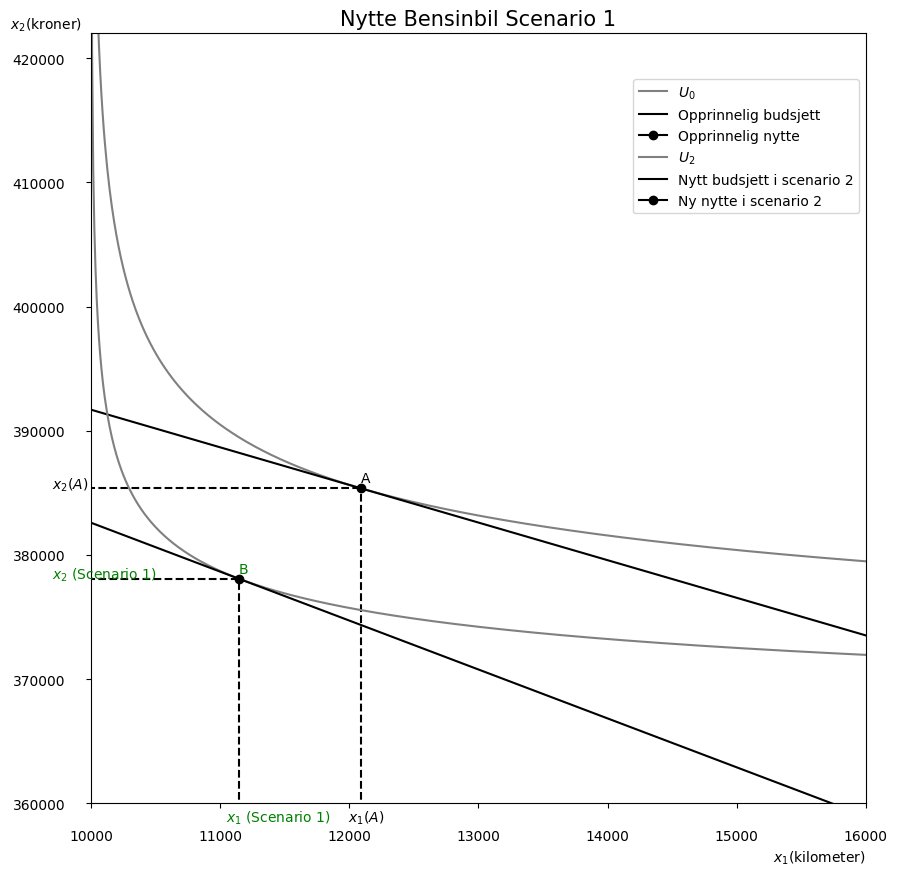

In [33]:
fig, ax = plt.subplots(figsize=(10, 10))



ax.plot(X, ind_k_fn(.2,10000,360000,X,bensin_nytte), color='grey',label='$U_0$')
ax.plot(X, budsjett(422000, X, 3.03, 1), color='black', label='Opprinnelig budsjett')
ax.plot(x_1_bensin_bil, x_2_bensin_bil , marker='o', color='black', label="Opprinnelig nytte")

ax.vlines(x_1_bensin_bil, 0, x_2_bensin_bil, ls='dashed', color='black')
ax.hlines(x_2_bensin_bil, 0, x_1_bensin_bil, ls='dashed', color='black')

ax.annotate('$x_1(A)$', (x_1_bensin_bil-100, 358500), annotation_clip=False)
ax.annotate('$x_2(A)$', (9700, x_2_bensin_bil), annotation_clip=False)
ax.annotate('A', (x_1_bensin_bil,x_2_bensin_bil+500))

ax.plot(X, ind_k_fn(.2,10000,360000,X,bensin_nytte_sc1), color='grey',label='$U_2$')
ax.plot(X, budsjett(422000, X, 3.94, 1), color='black', label='Nytt budsjett i scenario 2')
ax.plot(x_1_bensin_bil_sc1, x_2_bensin_bil_sc1 , marker='o', color='black', label="Ny nytte i scenario 2")

ax.vlines(x_1_bensin_bil_sc1, 0, x_2_bensin_bil_sc1, ls='dashed', color='black')
ax.hlines(x_2_bensin_bil_sc1, 0, x_1_bensin_bil_sc1, ls='dashed', color='black')

ax.annotate('$x_1$ (Scenario 1)', (x_1_bensin_bil_sc1-100, 358500), color='green', annotation_clip=False)
ax.annotate('$x_2$ (Scenario 1)', (9700, x_2_bensin_bil_sc1-1), color= 'green', annotation_clip=False)
ax.annotate('B', (x_1_bensin_bil_sc1,x_2_bensin_bil_sc1+500), color='green')






#moving x tick labels a little down
ax.tick_params(axis='both', which='major', pad=15)
#make the label further to the right
ax.set_ylabel('$x_2$(kroner)', loc='top', rotation=0, labelpad=-50)
ax.set_xlabel('$x_1$(kilometer)', loc='right', rotation=0)

#title
ax.set_title('Nytte Bensinbil Scenario 1', fontsize=15)

# Set x limits
ax.set_xlim(10000, 16000)
ax.set_ylim(360000, 422000)
# Show the legend
ax.legend(bbox_to_anchor=(1,0.95))


plt.savefig('nytte_bensin_scenario1.png', dpi=300, bbox_inches='tight')

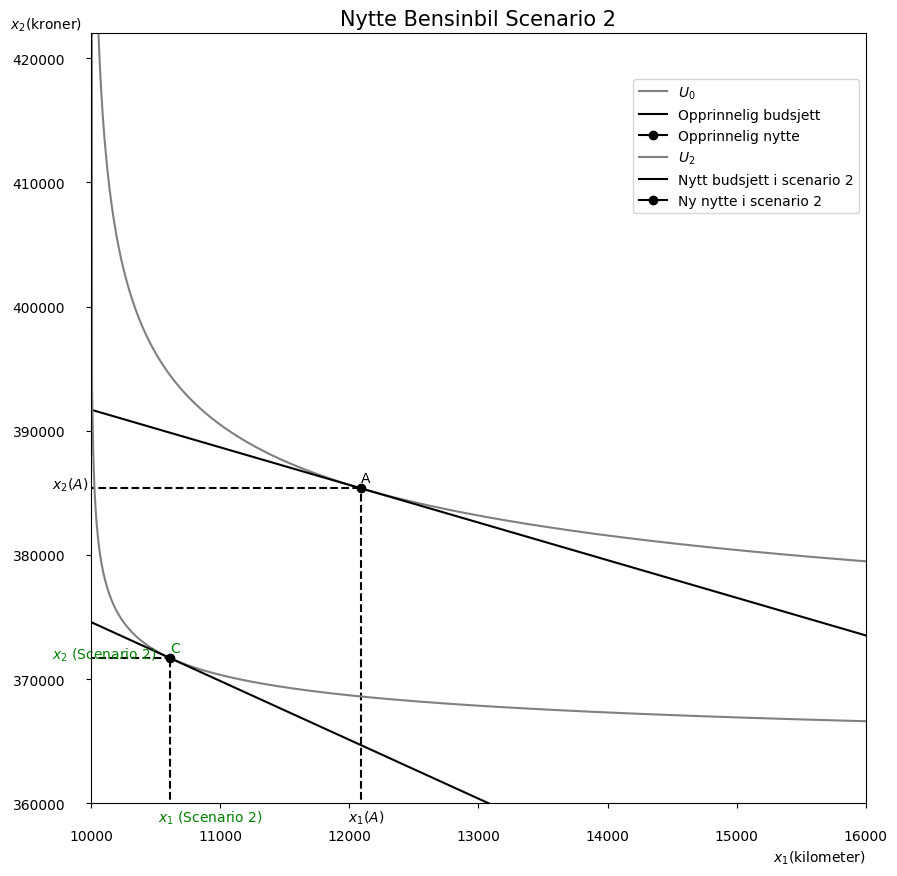

In [34]:
fig, ax = plt.subplots(figsize=(10, 10))



ax.plot(X, ind_k_fn(.2,10000,360000,X,bensin_nytte), color='grey',label='$U_0$')
ax.plot(X, budsjett(422000, X, 3.03, 1), color='black', label='Opprinnelig budsjett')
ax.plot(x_1_bensin_bil, x_2_bensin_bil , marker='o', color='black', label="Opprinnelig nytte")

ax.vlines(x_1_bensin_bil, 0, x_2_bensin_bil, ls='dashed', color='black')
ax.hlines(x_2_bensin_bil, 0, x_1_bensin_bil, ls='dashed', color='black')

ax.annotate('$x_1(A)$', (x_1_bensin_bil-100, 358500), annotation_clip=False)
ax.annotate('$x_2(A)$', (9700, x_2_bensin_bil), annotation_clip=False)
ax.annotate('A', (x_1_bensin_bil,x_2_bensin_bil+500))

ax.plot(X, ind_k_fn(.2,10000,360000,X,bensin_nytte_sc2), color='grey',label='$U_2$')
ax.plot(X, budsjett(422000, X, 4.74, 1), color='black', label='Nytt budsjett i scenario 2')
ax.plot(x_1_bensin_bil_sc2, x_2_bensin_bil_sc2 , marker='o', color='black', label="Ny nytte i scenario 2")

ax.vlines(x_1_bensin_bil_sc2, 0, x_2_bensin_bil_sc2, ls='dashed', color='black')
ax.hlines(x_2_bensin_bil_sc2, 0, x_1_bensin_bil_sc2, ls='dashed', color='black')

ax.annotate('$x_1$ (Scenario 2)', (x_1_bensin_bil_sc2-100, 358500), color='green', annotation_clip=False)
ax.annotate('$x_2$ (Scenario 2)', (9700, x_2_bensin_bil_sc2-1), color= 'green', annotation_clip=False)
ax.annotate('C', (x_1_bensin_bil_sc2,x_2_bensin_bil_sc2+500), color='green')



#title
ax.set_title('Nytte Bensinbil Scenario 2', fontsize=15)


#moving x tick labels a little down
ax.tick_params(axis='both', which='major', pad=15)
#make the label further to the right
ax.set_ylabel('$x_2$(kroner)', loc='top', rotation=0, labelpad=-50)
ax.set_xlabel('$x_1$(kilometer)', loc='right', rotation=0)

# Set x limits
ax.set_xlim(10000, 16000)
ax.set_ylim(360000, 422000)
# Show the legend
ax.legend(bbox_to_anchor=(1,0.95))


plt.savefig('nytte_bensin_scenario2.png', dpi=300, bbox_inches='tight')

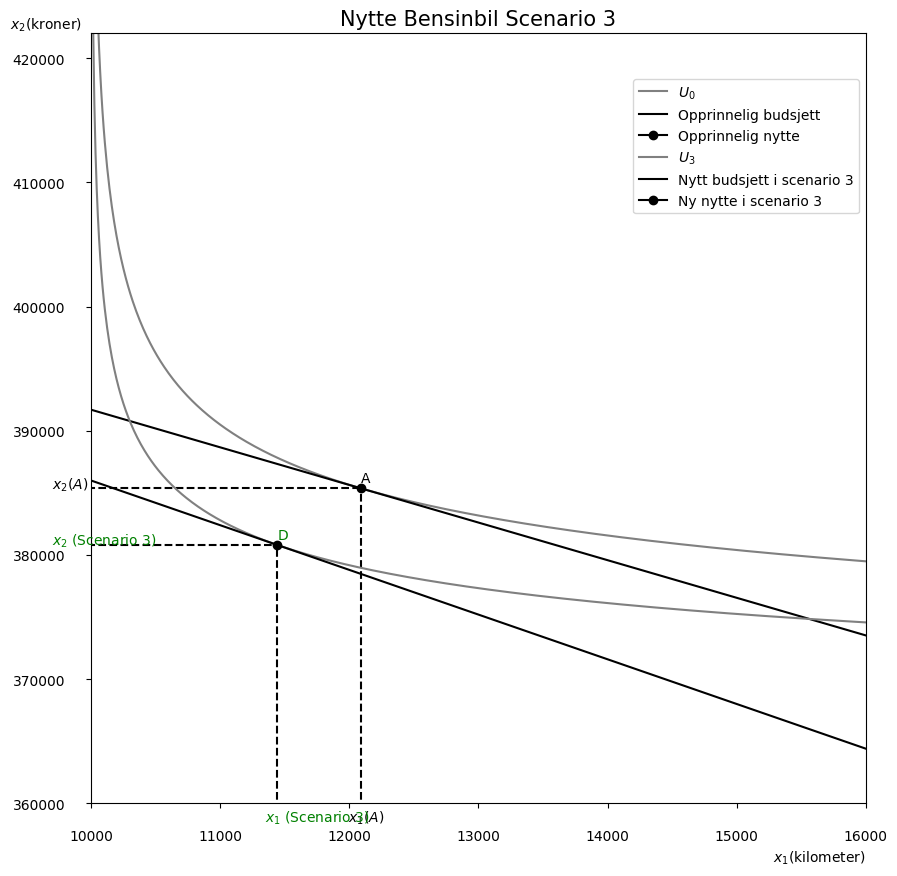

In [35]:
fig, ax = plt.subplots(figsize=(10, 10))



ax.plot(X, ind_k_fn(.2,10000,360000,X,bensin_nytte), color='grey',label='$U_0$')
ax.plot(X, budsjett(422000, X, 3.03, 1), color='black', label='Opprinnelig budsjett')
ax.plot(x_1_bensin_bil, x_2_bensin_bil , marker='o', color='black', label="Opprinnelig nytte")

ax.vlines(x_1_bensin_bil, 0, x_2_bensin_bil, ls='dashed', color='black')
ax.hlines(x_2_bensin_bil, 0, x_1_bensin_bil, ls='dashed', color='black')

ax.annotate('$x_1(A)$', (x_1_bensin_bil-100, 358500), annotation_clip=False)
ax.annotate('$x_2(A)$', (9700, x_2_bensin_bil), annotation_clip=False)
ax.annotate('A', (x_1_bensin_bil,x_2_bensin_bil+500))

ax.plot(X, ind_k_fn(.2,10000,360000,X,bensin_nytte_sc3), color='grey',label='$U_3$')
ax.plot(X, budsjett(422000, X, 3.60, 1), color='black', label='Nytt budsjett i scenario 3')
ax.plot(x_1_bensin_bil_sc3, x_2_bensin_bil_sc3 , marker='o', color='black', label="Ny nytte i scenario 3")

ax.vlines(x_1_bensin_bil_sc3, 0, x_2_bensin_bil_sc3, ls='dashed', color='black')
ax.hlines(x_2_bensin_bil_sc3, 0, x_1_bensin_bil_sc3, ls='dashed', color='black')

ax.annotate('$x_1$ (Scenario 3)', (x_1_bensin_bil_sc3-100, 358500), color='green', annotation_clip=False)
ax.annotate('$x_2$ (Scenario 3)', (9700, x_2_bensin_bil_sc3-1), color= 'green', annotation_clip=False)
ax.annotate('D', (x_1_bensin_bil_sc3,x_2_bensin_bil_sc3+500), color='green')






#moving x tick labels a little down
ax.tick_params(axis='both', which='major', pad=15)
#make the label further to the right
ax.set_ylabel('$x_2$(kroner)', loc='top', rotation=0, labelpad=-50)
ax.set_xlabel('$x_1$(kilometer)', loc='right', rotation=0)


#title
ax.set_title('Nytte Bensinbil Scenario 3', fontsize=15)


# Set x limits
ax.set_xlim(10000, 16000)
ax.set_ylim(360000, 422000)
# Show the legend
ax.legend(bbox_to_anchor=(1,0.95))


plt.savefig('nytte_bensin_scenario3.png', dpi=300, bbox_inches='tight')

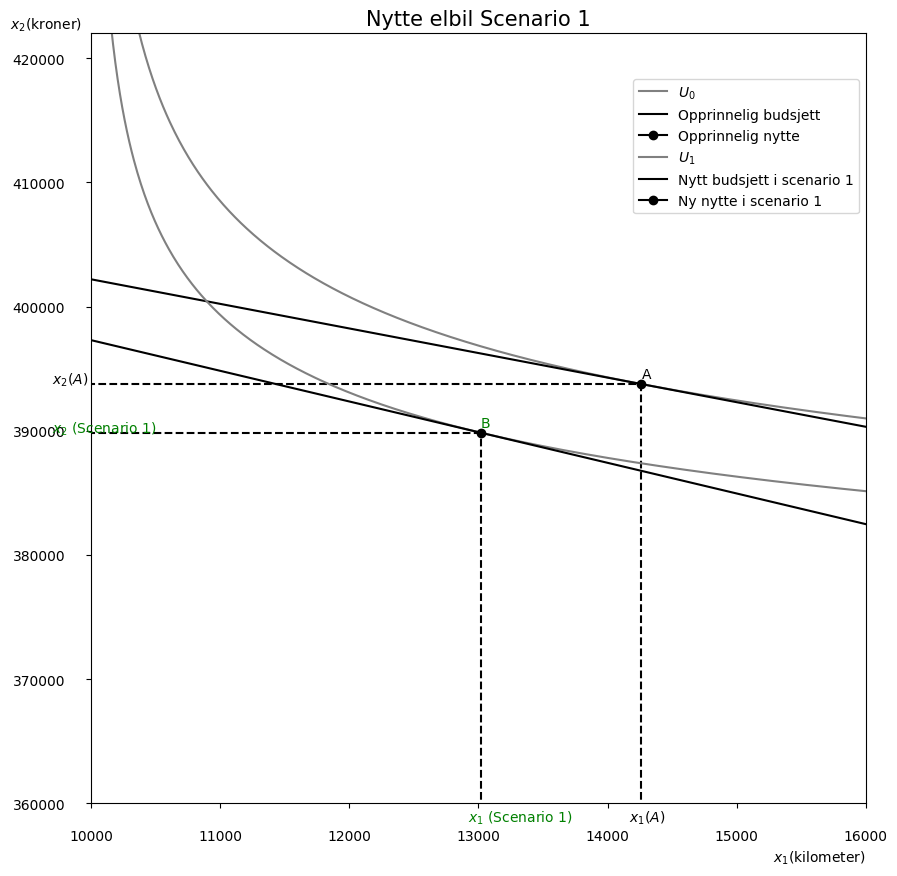

In [36]:

fig, ax = plt.subplots(figsize=(10, 10))

# Remove numbers from the axes
#ax.set_xticks([])
#ax.set_yticks([])


ax.plot(X, ind_k_fn(.2,10000,360000,X,elbil_nytte), color='grey',label='$U_0$')
ax.plot(X, budsjett(422000, X, 1.98, 1), color='black', label='Opprinnelig budsjett')
ax.plot(x_1_elbil_bil, x_2_elbil_bil , marker='o', color='black', label="Opprinnelig nytte")

ax.vlines(x_1_elbil_bil, 0, x_2_elbil_bil, ls='dashed', color='black')
ax.hlines(x_2_elbil_bil, 0, x_1_elbil_bil, ls='dashed', color='black')

ax.annotate('$x_1(A)$', (x_1_elbil_bil-100, 358500), annotation_clip=False)
ax.annotate('$x_2(A)$', (9700, x_2_elbil_bil), annotation_clip=False)
ax.annotate('A', (x_1_elbil_bil,x_2_elbil_bil+500))

ax.plot(X, ind_k_fn(.2,10000,360000,X,elbil_nytte_sc1), color='grey',label='$U_1$')
ax.plot(X, budsjett(422000, X, 2.47, 1), color='black', label='Nytt budsjett i scenario 1')
ax.plot(x_1_elbil_bil_sc1, x_2_elbil_bil_sc1 , marker='o', color='black', label="Ny nytte i scenario 1")

ax.vlines(x_1_elbil_bil_sc1, 0, x_2_elbil_bil_sc1, ls='dashed', color='black')
ax.hlines(x_2_elbil_bil_sc1, 0, x_1_elbil_bil_sc1, ls='dashed', color='black')

ax.annotate('$x_1$ (Scenario 1)', (x_1_elbil_bil_sc1-100, 358500), color='green', annotation_clip=False)
ax.annotate('$x_2$ (Scenario 1)', (9700, x_2_elbil_bil_sc1-1), color= 'green', annotation_clip=False)
ax.annotate('B', (x_1_elbil_bil_sc1,x_2_elbil_bil_sc1+500), color='green')


#moving x tick labels a little down
ax.tick_params(axis='both', which='major', pad=15)
#make the label further to the right
ax.set_ylabel('$x_2$(kroner)', loc='top', rotation=0, labelpad=-50)
ax.set_xlabel('$x_1$(kilometer)', loc='right', rotation=0)

#title
ax.set_title('Nytte elbil Scenario 1', fontsize=15)


# Set x limits
ax.set_xlim(10000, 16000)
ax.set_ylim(360000, 422000)
# Show the legend
ax.legend(bbox_to_anchor=(1,0.95))

plt.savefig('nytte_elbil_scenario1.png', dpi=300, bbox_inches='tight')

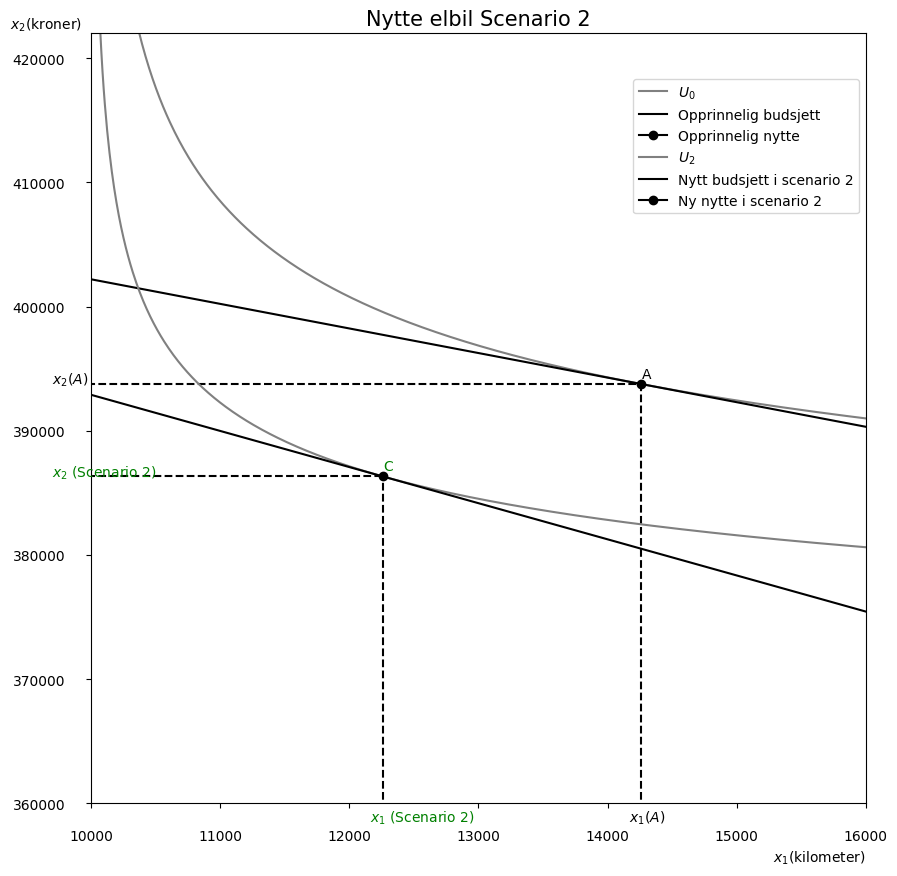

In [37]:
fig, ax = plt.subplots(figsize=(10, 10))


ax.plot(X, ind_k_fn(.2,10000,360000,X,elbil_nytte), color='grey',label='$U_0$')
ax.plot(X, budsjett(422000, X, 1.98, 1), color='black', label='Opprinnelig budsjett')
ax.plot(x_1_elbil_bil, x_2_elbil_bil , marker='o', color='black', label="Opprinnelig nytte")

ax.vlines(x_1_elbil_bil, 0, x_2_elbil_bil, ls='dashed', color='black')
ax.hlines(x_2_elbil_bil, 0, x_1_elbil_bil, ls='dashed', color='black')

ax.annotate('$x_1(A)$', (x_1_elbil_bil-100, 358500), annotation_clip=False)
ax.annotate('$x_2(A)$', (9700, x_2_elbil_bil), annotation_clip=False)
ax.annotate('A', (x_1_elbil_bil,x_2_elbil_bil+500))

ax.plot(X, ind_k_fn(.2,10000,360000,X,elbil_nytte_sc2), color='grey',label='$U_2$')
ax.plot(X, budsjett(422000, X, 2.91, 1), color='black', label='Nytt budsjett i scenario 2')
ax.plot(x_1_elbil_bil_sc2, x_2_elbil_bil_sc2 , marker='o', color='black', label="Ny nytte i scenario 2")

ax.vlines(x_1_elbil_bil_sc2, 0, x_2_elbil_bil_sc2, ls='dashed', color='black')
ax.hlines(x_2_elbil_bil_sc2, 0, x_1_elbil_bil_sc2, ls='dashed', color='black')

ax.annotate('$x_1$ (Scenario 2)', (x_1_elbil_bil_sc2-100, 358500), color='green', annotation_clip=False)
ax.annotate('$x_2$ (Scenario 2)', (9700, x_2_elbil_bil_sc2-1), color= 'green', annotation_clip=False)
ax.annotate('C', (x_1_elbil_bil_sc2,x_2_elbil_bil_sc2+500), color='green')






#moving x tick labels a little down
ax.tick_params(axis='both', which='major', pad=15)
#make the label further to the right
ax.set_ylabel('$x_2$(kroner)', loc='top', rotation=0, labelpad=-50)
ax.set_xlabel('$x_1$(kilometer)', loc='right', rotation=0)


#title
ax.set_title('Nytte elbil Scenario 2', fontsize=15)



# Set x limits
ax.set_xlim(10000, 16000)
ax.set_ylim(360000, 422000)
# Show the legend
ax.legend(bbox_to_anchor=(1,0.95))

plt.savefig('nytte_elbil_scenario2.png', dpi=300, bbox_inches='tight')

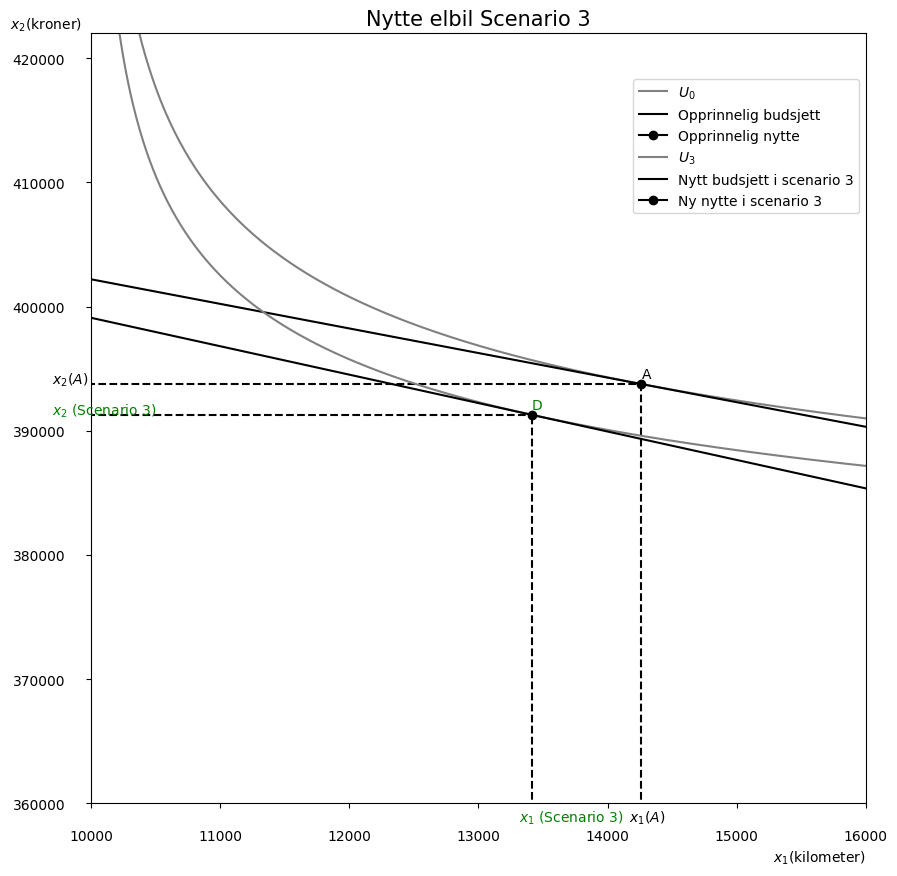

In [38]:

bta_1, bta_2, gma_1, gma_2 = sp.symbols('\u03B2_1 \u03B2_2 \gamma_1 \gamma_2', real=True, positive=True)
x_1, x_2, p_1, p_2, m=sp.symbols("x_1 x_2 p_1 p_2 m", real=True, positive=True)
x_1_eq = gma_1 + (bta_1/p_1)*(m-p_1*gma_1-p_2*gma_2)
x_2_eq = gma_2 + (bta_2/p_2)*(m-p_1*gma_1-p_2*gma_2)


nytte_sg = bta_1*sp.log(x_1-gma_1) + (1-bta_1)*sp.log(x_2-gma_2)
V = nytte_sg.subs([(x_1, x_1_eq), (x_2, x_2_eq)]) 


def budsjett(M, x_1, p_1, p_2):
    return M/p_2 - (p_1*x_1/p_2)


def ind_k_fn(bta_1,gma_1,gma_2,x_1,U_0):
    return gma_2 + np.exp((bta_1*np.log(x_1-gma_1)-U_0)/(bta_1-1))

# Create an array X that ensures x-gamma > 0
X = np.linspace (10000.01,100000,10000)

fig, ax = plt.subplots(figsize=(10, 10))

# Remove numbers from the axes
#ax.set_xticks([])
#ax.set_yticks([])


ax.plot(X, ind_k_fn(.2,10000,360000,X,elbil_nytte), color='grey',label='$U_0$')
ax.plot(X, budsjett(422000, X, 1.98, 1), color='black', label='Opprinnelig budsjett')
ax.plot(x_1_elbil_bil, x_2_elbil_bil , marker='o', color='black', label="Opprinnelig nytte")

ax.vlines(x_1_elbil_bil, 0, x_2_elbil_bil, ls='dashed', color='black')
ax.hlines(x_2_elbil_bil, 0, x_1_elbil_bil, ls='dashed', color='black')

ax.annotate('$x_1(A)$', (x_1_elbil_bil-100, 358500), annotation_clip=False)
ax.annotate('$x_2(A)$', (9700, x_2_elbil_bil), annotation_clip=False)
ax.annotate('A', (x_1_elbil_bil,x_2_elbil_bil+500))

ax.plot(X, ind_k_fn(.2,10000,360000,X,elbil_nytte_sc3), color='grey',label='$U_3$')
ax.plot(X, budsjett(422000, X, 2.29, 1), color='black', label='Nytt budsjett i scenario 3')
ax.plot(x_1_elbil_bil_sc3, x_2_elbil_bil_sc3 , marker='o', color='black', label="Ny nytte i scenario 3")

ax.vlines(x_1_elbil_bil_sc3, 0, x_2_elbil_bil_sc3, ls='dashed', color='black')
ax.hlines(x_2_elbil_bil_sc3, 0, x_1_elbil_bil_sc3, ls='dashed', color='black')

ax.annotate('$x_1$ (Scenario 3)', (x_1_elbil_bil_sc3-100, 358500), color='green', annotation_clip=False)
ax.annotate('$x_2$ (Scenario 3)', (9700, x_2_elbil_bil_sc3-1), color= 'green', annotation_clip=False)
ax.annotate('D', (x_1_elbil_bil_sc3,x_2_elbil_bil_sc3+500), color='green')


#moving x tick labels a little down
ax.tick_params(axis='both', which='major', pad=15)
#make the label further to the right
ax.set_ylabel('$x_2$(kroner)', loc='top', rotation=0, labelpad=-50)
ax.set_xlabel('$x_1$(kilometer)', loc='right', rotation=0)


#title
ax.set_title('Nytte elbil Scenario 3', fontsize=15)



# Set x limits
ax.set_xlim(10000, 16000)
ax.set_ylim(360000, 422000)
# Show the legend
ax.legend(bbox_to_anchor=(1,0.95))

plt.savefig('nytte_elbil_scenario3.png', dpi=300, bbox_inches='tight')